<span style="color: orange; font-family: Calibri Light;">
  <h1><b>BERTopic Model: Word2Vec Sentence Transformer</b></h1>
</span>
<span style = "font-family: Calibri Light">
    In this model, we used the BerTopic model with a document embedding/sentence transformer built on word2vec on partly pre-processed text
</span>

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>I. Setup Environment</b></h2>
</span>

In [1]:
import os

os.environ['PATH'] = "/home/ec2-user/.local/bin:" + os.environ['PATH']

In [1]:
%pip install bertopic gensim

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Obtaining dependency information for bertopic from https://files.pythonhosted.org/packages/06/49/f395e2e4d21dd49803494c8aec6087db61ea0ba211c6e5e57540b23334eb/bertopic-0.15.0-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.9 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 855.6 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 710.7 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for plotly>=4.7.0 from h

In [1]:
import pandas as pd
import numpy as np

import re

import ast
import csv
import os
import random
import time
import pickle
from collections import Counter

from glob import glob

#NLP libraries
from gensim.models import Word2Vec
from gensim.utils import tokenize
from gensim.models.phrases import Phrases
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired
from bertopic.vectorizers import  ClassTfidfTransformer
from sentence_transformers import SentenceTransformer

#for vis
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = 'iframe'

from umap import UMAP

from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

from hdbscan import HDBSCAN

2023-09-24 04:43:34.559689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 04:43:34.697657: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-24 04:43:35.429535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-24 04:43:35.429608: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
random.seed(8)  # Set the seed for Python's random module
np.random.seed(8)  # Set the seed for NumPy's random module

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>II. Import and Prepare Data for Model</b></h2>
</span>

In [3]:
#access dataset files
folder_path = os.path.join("..", "../Data")
file_type = "*.csv"

#list of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../../Data/comments.csv',
 '../../Data/emoji_subset.csv',
 '../../Data/full_posts.csv',
 '../../Data/bert_train_lemma.csv',
 '../../Data/bert_train_no_prep.csv',
 '../../Data/full_data_no_preprocessing.csv',
 '../../Data/subset_sample_no_label.csv',
 '../../Data/test_data_lemma.csv',
 '../../Data/bert-data-sw.csv']

In [4]:
data_filepath = '' #file path for csv file of scraped comments 

for path in document_path:
    if "train_no_prep" in path:
        data_filepath = data_filepath + path

print (data_filepath)
    

../../Data/bert_train_no_prep.csv


In [5]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


train_data = pd.read_csv(data_filepath, converters ={'tokens':list_converter})
train_data = train_data.dropna(subset = ['long_text'])
train_data = train_data.drop(columns = ['index'])

In [6]:
#sort by data created
train_data.sort_values(by='date_created', inplace = True, ignore_index = True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127686 entries, 0 to 127685
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text_type     127686 non-null  object
 1   ID            127686 non-null  object
 2   date_created  127686 non-null  object
 3   year          127686 non-null  int64 
 4   long_text     127686 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.9+ MB


In [7]:
train_data.head()

,text_type,ID,date_created,year,long_text
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!"""
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...
3,comment,c6d1cs1,2012-09-25 08:04:04,2012,seriously?
4,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i..."


In [8]:
#check for empty values
train_data[train_data['long_text'].isna()]

,text_type,ID,date_created,year,long_text


In [9]:
#remove HTML, URLs and newline and tab characters

def text_preprocess(text):
    #remove HTMLs and URLs
    text = re.sub(r'<.*?>|http\S+', '', text)
    
    #remove newline and tab characters
    text = text.replace('\n', ' ').replace ('\t', ' ')
    
    #remove extra whitespace
    text = re.sub(r'\s+',' ', text)
    
    return text

In [10]:
train_data['prep_text'] = train_data['long_text'].apply(text_preprocess)

In [11]:
train_data.head()

,text_type,ID,date_created,year,long_text,prep_text
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.,That dessert's a bit rich for me.
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!""","""A SILVER one?! I HATE YOU DAD!"""
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,Yet i stared at the picture for a good 45 seco...
3,comment,c6d1cs1,2012-09-25 08:04:04,2012,seriously?,seriously?
4,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...","[FYSR] = from your sister subreddit. IMO, its ..."


In [12]:
#remove rows with less than 5 words
train_data = train_data[train_data['prep_text'].apply(lambda x:len(x.split()) > 5)]

In [13]:
train_data.head()

,text_type,ID,date_created,year,long_text,prep_text
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.,That dessert's a bit rich for me.
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!""","""A SILVER one?! I HATE YOU DAD!"""
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,Yet i stared at the picture for a good 45 seco...
4,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...","[FYSR] = from your sister subreddit. IMO, its ..."
5,comment,c6d46es,2012-09-25 12:32:08,2012,common give prince william harry a break he ju...,common give prince william harry a break he ju...


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98957 entries, 0 to 127683
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_type     98957 non-null  object
 1   ID            98957 non-null  object
 2   date_created  98957 non-null  object
 3   year          98957 non-null  int64 
 4   long_text     98957 non-null  object
 5   prep_text     98957 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.3+ MB


<span style="color: orange; font-family: Calibri Light;">
  <h2><b>III. Train Model</b></h2>
</span>
<p>First, we create word2vec embeddings, and create document vectors from that. Then we will train the model using different nr_topics (20,30,50) and compare their performance using quantitative measures such as coherence and topic diversity. Also, introduce larger min_cluster in the HDBSCAN model to reduce the presence of outliers.<br>
Coherence we will measure with 'c_v' and 'c_npmi', and topic diversity, we will measure uniqueness and exclusivity.</p>

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>a. Create Sentence Embeddings with Word2Vec model</b></h2>
</span>

In [15]:
#create custom embeddings using gensim word2vec - no bigrams

#text corpus as list of strings
corpus = train_data['prep_text'].apply(lambda text: text.split()).tolist()

#instantiate the word2vec model
wv_model = Word2Vec(window = 5, min_count = 2, workers = 4, vector_size = 100)

#build vocabulary
wv_model.build_vocab(corpus, progress_per = 1000)

#train model
wv_model.train(corpus, total_examples = wv_model.corpus_count, epochs = wv_model.epochs)

#save model
wv_model.save('../bertopic_models/word2vec_no_bigrams')

In [16]:
#load the word2vec model
wv_model = Word2Vec.load('../bertopic_models/word2vec_no_bigrams')

In [17]:
#check word2vec model performance
wv_model.wv.most_similar('metro')

[('bus', 0.8980985879898071),
 ('mall', 0.8648083806037903),
 ('airport', 0.8341067433357239),
 ('mosque', 0.8135827779769897),
 ('exit', 0.8106452226638794),
 ('station', 0.7969748377799988),
 ('hotel', 0.7900733947753906),
 ('beach', 0.7813221216201782),
 ('entrance', 0.7796363234519958),
 ('center', 0.7589206695556641)]

In [18]:
#create document embeddings
#code from Dylan Castillo https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/#train-word2vec-model

def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return np.array(features)


#Wrapper for Word2Vec to create an `encode` method needed for BerTopic. 
class wv_embedder:
    def __init__(self,model):
        self.model = model
        
    def encode(self, list_of_docs):
        return vectorize(list_of_docs, self.model)
    
custom_embeddings = wv_embedder(wv_model)

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>b. Create Sentence Embeddings with Word2Vec model</b></h2>
</span>

In [15]:
#prepare data for bertopic model
docs = train_data['prep_text'].values

In [20]:
#prepare sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=125)
hdbscan_model = HDBSCAN(min_cluster_size = 80, min_samples = 10, metric = 'euclidean', prediction_data = True)
vectorizer_model = CountVectorizer(max_df = 1000, min_df = 10, stop_words = 'english', ngram_range = (1,2))
ctfidf_model = ClassTfidfTransformer(bm25_weighting= True, reduce_frequent_words=True)
representation_model = MaximalMarginalRelevance(diversity = 0.5)

In [21]:
#train bert models

topic_range = [20,30,50]
cv_scores = []
cnpmi_scores = []
topic_uniqueness = []
topic_exclusivity = []
#loop over topics_range and calculate topic coherence and topic diversity

start_time = time.time()

for num_topics in topic_range:
    #train bertopic model
    model = BERTopic(embedding_model=custom_embeddings, umap_model=umap_model, 
                 hdbscan_model = hdbscan_model,vectorizer_model=vectorizer_model,
                 ctfidf_model= ctfidf_model, representation_model= representation_model,
                nr_topics = num_topics)
    
    topics,_ = model.fit_transform(docs)
    
    #calculate coherence score(c_v)
    topic_reps = model.get_topic_info()
    dictionary = Dictionary([words.split() for words in docs])
    corpus = [dictionary.doc2bow(doc.split()) for doc in docs]
    cv = CoherenceModel(topics = topic_reps['Representation'].tolist(),
                       texts = [doc.split() for doc in train_data['prep_text'].values],
                        dictionary = dictionary, coherence = 'c_v')
    cv_coherence =cv.get_coherence()
    cv_scores.append(cv_coherence)
    
    #calculate coherence score(c_npmi)
    cnpmi = CoherenceModel(topics = topic_reps['Representation'].tolist(),
                       texts = [doc.split() for doc in train_data['prep_text'].values],
                        dictionary = dictionary, coherence = 'c_npmi')
    cnpmi_coherence =cnpmi.get_coherence()
    cnpmi_scores.append(cnpmi_coherence)
    
    #calculate topic diversity - exclusivity
    n = 10
    #unique topics
    unique_topics = model.get_topic_freq()['Topic'].tolist()
    #remove outlier topics
    unique_topics = [topic for topic in unique_topics if topics != -1]
    #get top_n words for each topic
    topic_words = [model.get_topic(topic_id)[:n] for topic_id in unique_topics]
    all_top_words = [word for topic in topic_words for word,_ in topic]
    #calculate exclusivity
    word_counts = Counter(all_top_words)
    exclusivity = sum(1 for word, count in word_counts.items() if count == 1)/ len(all_top_words)
    topic_exclusivity.append(exclusivity)
    #calculate topic diversity - uniqueness
    uniqueness = len(set(all_top_words))/ (n * len(unique_topics))
    topic_uniqueness.append(uniqueness)
    
    
    print(f"For {num_topics} topics:\nCoherence(c_v) = {cv_coherence},\nCoherence(c_npmi) = {cnpmi_coherence},\nTopic Diversity-Uniquesness = {uniqueness},\nTopic Diversity-Exclusivity = {exclusivity}")
    
print(f"This code took {(time.time() - start_time)/60 :.2f} minutes to execute")    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [22]:
evals = {'topics': topic_range,'coherence(c_v)': cv_scores, 'coherence(c_npmi)':cnpmi_scores, 'topic_diveristy_uniqueness':topic_uniqueness, 'topic_diversity_exclusivity': topic_exclusivity}
bert_w2v_lemma_eval = pd.DataFrame(evals)

bert_w2v_lemma_eval.to_csv('training_results/bert_w2v_evals.csv')
bert_w2v_lemma_eval

,topics,coherence(c_v),coherence(c_npmi),topic_diveristy_uniqueness,topic_diversity_exclusivity
0,20,0.338592,-0.206665,0.955000,0.910000
1,30,0.327559,-0.228424,0.953333,0.906667
2,50,0.347242,-0.219585,0.936000,0.876000


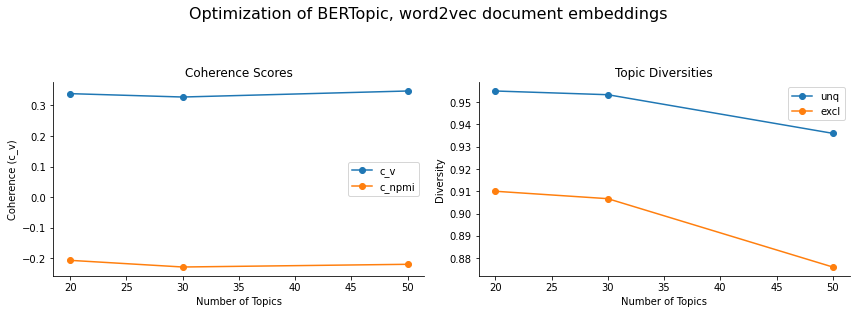

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))
fig.suptitle('Optimization of BERTopic, word2vec document embeddings', fontsize=16, y=1.08)

# Plot coherence scores
ax1 = plt.subplot(1, 2, 1)
ax1.plot(topic_range, cv_scores, marker='o', label = 'c_v')
ax1.plot(topic_range, cnpmi_scores, marker='o', label = 'c_npmi')
ax1.title.set_text('Coherence Scores')
ax1.legend()
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence (c_v)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Plot topic diversities
ax2 = plt.subplot(1, 2, 2)
ax2.plot(topic_range, topic_uniqueness, marker='o', label = 'unq')
ax2.plot(topic_range, topic_exclusivity, marker='o', label = 'excl')
ax2.title.set_text('Topic Diversities')
ax2.legend()
ax2.set_xlabel('Number of Topics')
ax2.set_ylabel('Diversity')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()

# Save the figure
fig.savefig('training_results/bertopic_w2v_optimization.png', bbox_inches='tight', dpi=300)

plt.show()


<span style="color: orange; font-family: Calibri Light;">
  <h2><b>IV. Select Optimal Model</b></h2>
</span>

In [25]:
#build bertopic model with custom embeddings

# Initiate BERTopic
model = BERTopic(umap_model = umap_model, hdbscan_model = hdbscan_model,
                 vectorizer_model = vectorizer_model,ctfidf_model=ctfidf_model,
                 representation_model= representation_model,embedding_model = custom_embeddings,
                  nr_topics = 50,verbose = True)

start_time = time.time()

#train model
topics,_= model.fit_transform(docs)

print (f"This project took {(time.time() - start_time)/60 :.2f} minutes to complete")

Batches:   0%|          | 0/3093 [00:00<?, ?it/s]

2023-09-18 07:31:53,348 - BERTopic - Transformed documents to Embeddings
2023-09-18 07:34:20,350 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-18 07:34:27,504 - BERTopic - Clustered reduced embeddings
2023-09-18 07:34:52,613 - BERTopic - Reduced number of topics from 191 to 50


This project took 4.03 minutes to complete


In [27]:
#save model
model.save("../bertopic_models/model2_w2v")
print ('model saved')

/usr/local/lib64/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



model saved


In [16]:
model = BERTopic.load('../bertopic_models/model2_w2v')

In [11]:
model.visualize_topics()

In [17]:
topics_df = model.get_topic_info()
topics_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,49352,-1_food_car_money_got,"[food, car, money, got, yes, world, 10, job, l...",[There is a study which says you can judge a p...
1,0,6506,0_uae_sharjah_visa_salary,"[uae, sharjah, visa, salary, live, zayed, jobs...","[I assume it's 50k AED a month, thus 600k AED ..."
2,1,2517,1_expo_metro_burj khalifa_buildings,"[expo, metro, burj khalifa, buildings, jlt, ma...",[Can really not be answered without a budget i...
3,2,2380,2_zomato_talabat_ads_crypto,"[zomato, talabat, ads, crypto, scammers, custo...",[You are right it’s not the fun part the fun p...
4,3,2268,3_racism_slave_expats_brown,"[racism, slave, expats, brown, african, russia...",[I feel absolutely fine. It is what it is. If ...
5,4,2234,4_rent_estate_agent_month,"[rent, estate, agent, month, income, villas, i...",[Landlord wanted to move into the property but...
6,5,2224,5_gn_meme_gulf_articles,"[gn, meme, gulf, articles, downvoted, khaleej ...",[Ban both khaleej times and gulf news. Good in...
7,6,1988,6_weather_summer_ac_desert,"[weather, summer, ac, desert, sun, sweat, jebe...",[Emirati. To endure summer and not be impacted...
8,7,1985,7_chips_kfc_oman_tea,"[chips, kfc, oman, tea, shake, 00, fresh, smel...",[Mutton Shawarma is not actually mutton This i...
9,8,1691,8_speed_lanes_limit_parking,"[speed, lanes, limit, parking, traffic, 140, d...",[There is not a single post of mine where I sa...


In [32]:
topics_df.to_csv('training_results/bert_w2v_topics_term.csv')

In [18]:
model.visualize_barchart(topics = [3,4,6,8,31,48])

In [19]:
model.visualize_barchart(top_n_topics=50, n_words = 50)

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>V. Retrieve Data with Topic Assignments</b></h2>
</span>

In [20]:
#create dataframe with topic assignments
t_df = model.get_document_info(docs)
t_df.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,That dessert's a bit rich for me.,-1,-1_food_car_money_got,"[food, car, money, got, yes, world, 10, job, l...",[There is a study which says you can judge a p...,food - car - money - got - yes - world - 10 - ...,0.000000,False
1,"""A SILVER one?! I HATE YOU DAD!""",17,17_dm_congratulations_thanks sharing_prayers,"[dm, congratulations, thanks sharing, prayers,...","[Congratulations and good luck OP! Cheers 🥂, T...",dm - congratulations - thanks sharing - prayer...,0.465794,False
2,Yet i stared at the picture for a good 45 seco...,-1,-1_food_car_money_got,"[food, car, money, got, yes, world, 10, job, l...",[There is a study which says you can judge a p...,food - car - money - got - yes - world - 10 - ...,0.000000,False
3,"[FYSR] = from your sister subreddit. IMO, its ...",0,0_uae_sharjah_visa_salary,"[uae, sharjah, visa, salary, live, zayed, jobs...","[I assume it's 50k AED a month, thus 600k AED ...",uae - sharjah - visa - salary - live - zayed -...,1.000000,False
4,common give prince william harry a break he ju...,21,21_laughing_lmao_combat_knife,"[laughing, lmao, combat, knife, punch, accurat...",[Oh my god. I have to cover my mouth just to n...,laughing - lmao - combat - knife - punch - acc...,0.976508,False


In [21]:
#topic assignment column subset
assigned_topics = t_df[['Topic', 'Name']].copy()
assigned_topics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98957 entries, 0 to 98956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Topic   98957 non-null  int64 
 1   Name    98957 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [22]:
train_data_label = train_data.copy() #create copy of training data

In [23]:
train_data_label.reset_index(drop = True, inplace = True) #reindex to match topic assignemtn index

In [24]:
train_data_label[['topic', 'topic_name']] = assigned_topics #merge data

In [25]:
train_data_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98957 entries, 0 to 98956
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_type     98957 non-null  object
 1   ID            98957 non-null  object
 2   date_created  98957 non-null  object
 3   year          98957 non-null  int64 
 4   long_text     98957 non-null  object
 5   prep_text     98957 non-null  object
 6   topic         98957 non-null  int64 
 7   topic_name    98957 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.0+ MB


In [37]:
train_data_label.to_csv('training_results/bert_model_w2v_label_train_data.csv')